In [1]:
import pandas as pd

In [2]:
path_file = "DataSet-pest.xlsx"
col_types = {"Documento":str, "Categoria":str}
df = pd.read_excel(path_file, dtype=col_types)
df

,Documento,Fecha,Texto,Categoria
0,0,2021-01-02 00:00:00,Primero Emelec y cinco años después el hermano...,no pest
1,1,2021-01-03 00:00:00,#ElAgroTrabaja por el bienestar de los ecuator...,Social
2,2,2021-01-01 00:00:00,Es nuestro derecho a recibir a tiempo los recu...,Económico
3,3,2020-03-23 00:00:00,Sin distanciamiento Incumpliendo disposiciones...,Social
4,4,2021-01-03 00:00:00,Guayaquil | La Intendencia de Policía del Guay...,Social
...,...,...,...,...
1335,1336,2021-02-25 00:00:00,Malecón 2000 Music Night Disfruta de música en...,no pest
1336,1337,2020-12-02 00:00:00,vivieron emocionantes jornadas deportivas en c...,no pest
1337,1338,2021-02-24 00:00:00,Monumento a Spencer les dará la bienvenida al ...,no pest
1338,1339,2021-02-25 00:00:00,"Renato Ibarra podría salir de Atlas, tras dife...",no pest


In [3]:
df.columns.values

array(['Documento', 'Fecha', 'Texto', 'Categoria'], dtype=object)

In [4]:
from io import StringIO
col = ['Texto', 'Categoria']
df = df[col]
df = df[pd.notnull(df['Categoria'])]

df.columns = ['Texto', 'Categoria']

df['category_id'] = df['Categoria'].factorize()[0]
category_id_df = df[['Categoria', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id','Categoria']].values)

df.head()


,Texto,Categoria,category_id
0,Primero Emelec y cinco años después el hermano...,no pest,0
1,#ElAgroTrabaja por el bienestar de los ecuator...,Social,1
2,Es nuestro derecho a recibir a tiempo los recu...,Económico,2
3,Sin distanciamiento Incumpliendo disposiciones...,Social,1
4,Guayaquil | La Intendencia de Policía del Guay...,Social,1


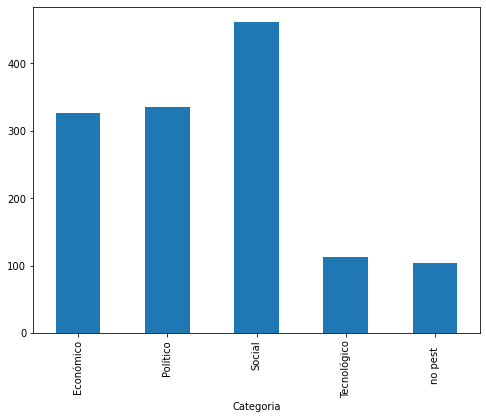

In [5]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df.groupby('Categoria').Texto.count().plot.bar(ylim=0)
plt.show()


In [6]:
df.Categoria[:20]

0       no pest  
1          Social
2       Económico
3          Social
4          Social
5          Social
6          Social
7          Social
8          Social
9          Social
10         Social
11    Tecnológico
12    Tecnológico
13         Social
14         Social
15         Social
16         Social
17         Social
18         Social
19         Social
Name: Categoria, dtype: object

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords 
tfidf = TfidfVectorizer (sublinear_tf = True, min_df = 5,norm = 'l2', encoding = 'latin-1', ngram_range = (1, 2), stop_words = 'english')
count_vect = CountVectorizer()
# features = tfidf.fit_transform(df['Categoria']) .toarray()
features = tfidf.fit_transform(df['Texto'].values.astype('U')) .toarray()
labels = df.Categoria
features.shape

(1340, 1345)

In [8]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(df['Texto'].values.astype('U')) .toarray()
X_train_counts.shape

(1340, 6525)

In [9]:
from sklearn.feature_extraction.text import TfidfTransformer
tf_transformer = TfidfTransformer(use_idf=False).fit(X_train_counts)
X_train_tf = tf_transformer.transform(X_train_counts)
X_train_tf.shape

(1340, 6525)

In [10]:
from sklearn.naive_bayes import MultinomialNB

clf = MultinomialNB().fit(features, df.Categoria)

In [11]:
from sklearn.feature_selection import chi2
import numpy as np

N = 2
for Categoria, category_id in sorted(category_to_id.items()):
    features_chi2 = chi2(features, labels == category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names()) [indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("# '{}':".format(Categoria))
    print(" .La mayoría de los unigramas correlacionados:\n. {}".format('\n.'.join(unigrams[-N:])))
    print(" .Bigrams más correlacionados:\n. {}".format('\n.'.join(bigrams[-N:])))



# 'Económico':
 .La mayoría de los unigramas correlacionados:
. elgobiernodetodos
.último
 .Bigrams más correlacionados:
. emergencia sanitaria
.empleo para
# 'Político':
 .La mayoría de los unigramas correlacionados:
. elgobiernodetodos
.último
 .Bigrams más correlacionados:
. emergencia sanitaria
.empleo para
# 'Social':
 .La mayoría de los unigramas correlacionados:
. elgobiernodetodos
.último
 .Bigrams más correlacionados:
. emergencia sanitaria
.empleo para
# 'Tecnológico':
 .La mayoría de los unigramas correlacionados:
. elgobiernodetodos
.último
 .Bigrams más correlacionados:
. emergencia sanitaria
.empleo para
# 'no pest  ':
 .La mayoría de los unigramas correlacionados:
. elgobiernodetodos
.último
 .Bigrams más correlacionados:
. emergencia sanitaria
.empleo para


In [12]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

X_train, X_test, y_train, y_test = train_test_split(df['Texto'], df['Categoria'],
random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [14]:
print(clf.predict(count_vect.transform([" Gastronomía y deporte se fusionan en homenaje a las fiestas julianas "])))

['Social']


In [15]:
print(clf.predict(count_vect.transform([" Banco Central: La economía ecuatoriana se contrajo 12,4 % en el segundo trimestre de 2020"])))

['Económico']


In [16]:
print(clf.predict(count_vect.transform([" Candidato Andrés Arauz lidera intención de voto en Ecuador "])))

['Político']


In [20]:
print(clf.predict(count_vect.transform([" comercio electrónico "])))

['Tecnológico']


In [34]:
print(clf.predict(count_vect.transform([" La ONU y la CIDH piden respuestas del Estado por masacre en cárceles; 33 colectivos hacen siete pedidos "])))

['Social']


In [35]:
print(clf.predict(count_vect.transform([" Inversión extranjera directa cae un 42 % durante la pandemia, son $107 millones menos que entraron a Ecuador "])))

['Económico']


In [36]:
print(clf.predict(count_vect.transform([" Sector turístico impulsa plataforma digital para incentivar viajes internos "])))

['Económico']


In [19]:
print(clf.predict(count_vect.transform([" Distrito de Salud entrega reconocimiento como Establecimientos 100% Libres de Humo de Tabaco a las instituciones públicas: Jefatura Política y Consejo de Protección de Derechos de Nobol, y  Jefatura política, Dinapen y Consejo de Segurida Ciudadana del cantón Daule. "])))

['Político']


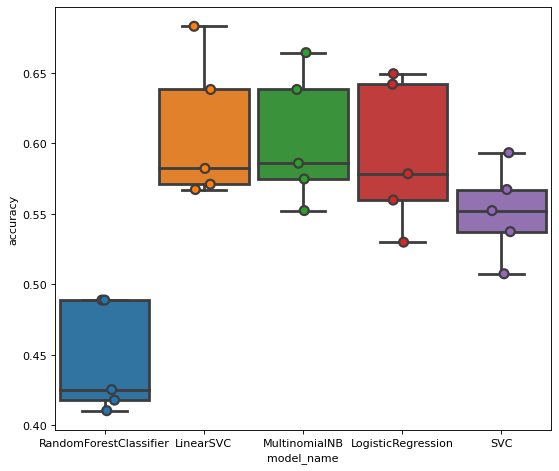

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, 
random_state=0),
         LinearSVC(),
         MultinomialNB(),
         LogisticRegression(random_state=0),
    SVC(gamma=2,C=1)
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name =model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate (accuracies):
        entries.append((model_name, fold_idx, accuracy))
    cv_df = pd.DataFrame(entries, columns=['model_name','fold_idx','accuracy'])
    
import seaborn as sns
import matplotlib.pyplot as plt
w = 8
h = 7
d = 80

plt.figure(figsize=(w,h), dpi=d)
sns.boxplot(x='model_name', y='accuracy', data=cv_df, width=0.9, fliersize=4, linewidth=2.5, whis= 4.6)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, size=8, jitter=True, edgecolor="gray", linewidth=2)

plt.show()

In [14]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.608209
LogisticRegression        0.591791
MultinomialNB             0.602985
RandomForestClassifier    0.446269
SVC                       0.551493
Name: accuracy, dtype: float64

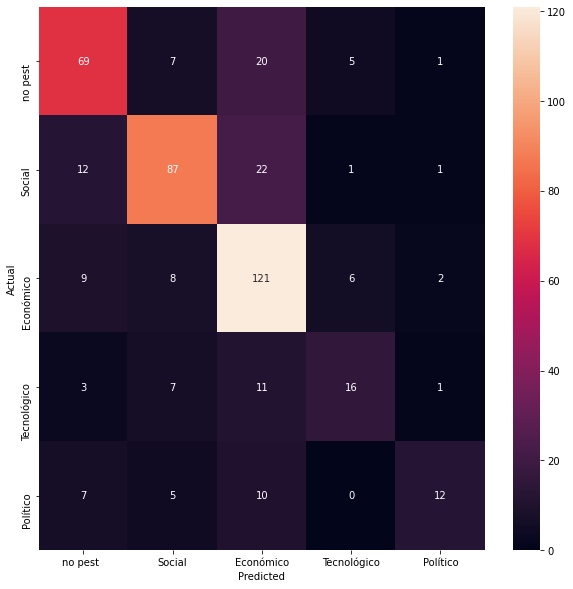

In [15]:
#Matriz de confusión
model = LinearSVC()

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33,
random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
           xticklabels=category_id_df.Categoria.values,
yticklabels=category_id_df.Categoria.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [16]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, target_names=df['Categoria'].unique()))

              precision    recall  f1-score   support

   no pest         0.69      0.68      0.68       102
      Social       0.76      0.71      0.73       123
   Económico       0.66      0.83      0.73       146
 Tecnológico       0.57      0.42      0.48        38
    Político       0.71      0.35      0.47        34

    accuracy                           0.69       443
   macro avg       0.68      0.60      0.62       443
weighted avg       0.69      0.69      0.68       443



In [18]:
X_test.shape

(443, 1345)